In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns
import pandas as pd
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.metrics.wasserstein_kuhn import kuhn_transport
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.MMD_torch import compute_rbf_mmd,median_heuristic
from labproject.data import get_distribution
from labproject.utils import set_seed
from dataclasses import dataclass

set_seed(0)



0

In [2]:
#Base distribution
toy_data = get_distribution("toy_2d")
MOG = toy_data()
num_samples = 1000
mixture_samples =MOG.sample(num_samples)
mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)

/tmp/ipykernel_45837/4048455916.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)


In [3]:
dpi = 150
plt.style.use("../../matplotlibrc")
plt.rcParams.update({"figure.dpi": dpi})



@dataclass
class FigureLayout:
    width_in_pt: float
    width_grid: int
    base_font_size: int = 8
    scale_factor: float = 1.0

    # matplotlib uses inch
    def _get_grid_in_inch(self, w_grid, h_grid):
        pt_to_inch = 1 / 72
        assert w_grid <= self.width_grid
        return (
            (w_grid / self.width_grid) * self.width_in_pt * pt_to_inch,
            (h_grid / self.width_grid) * self.width_in_pt * pt_to_inch,
        )

    def get_rc(self, w_grid, h_grid):
        return {
            "figure.figsize": self._get_grid_in_inch(w_grid, h_grid),
            "font.size": self.base_font_size * self.scale_factor,
        }
    
textwidth=469
fig_handler = FigureLayout(469,100)
params = fig_handler.get_rc(40,30)
plt.rcParams.update(params)


In [4]:
class Gauss(nn.Module):
    def __init__(self,dim):
        super(Gauss, self).__init__()
        self.mean = nn.Parameter(torch.zeros(dim))
        self.lower_triangular = nn.Parameter(torch.ones(dim*(dim+1)//2))
        self._row_ix, self._column_ix = torch.triu_indices(dim,dim)
        self.dim = dim

    def forward(self, noise):
        sample = self.cov_lt().matmul(noise.transpose(-2,-1)).transpose(-2,-1) + self.mean.unsqueeze(0)
        return sample
    
    def sample(self,size):
        return self.forward(torch.randn(size, self.dim))
    
    def cov(self):
        return self.cov_lt().matmul(self.cov_lt().transpose(-2,-1))
    
    def cov_lt(self):
        cov = torch.zeros(self.dim,self.dim)
        cov[self._row_ix,self._column_ix] = self.lower_triangular
        return cov






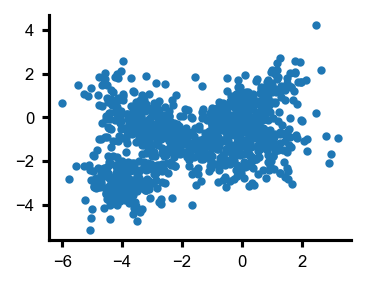

In [5]:
plt.scatter(mixture_samples[:, 0], mixture_samples[:, 1], label="Mixture of Gaussians")

In [6]:
# C2ST

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 10)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(10, 10)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x.squeeze()
    
nnc = NN()

loss_fn = torch.nn.BCELoss()  # binary cross entropy
gauss_model_C2ST = Gauss(dim=2)
num_samples = 10000


In [7]:


optimizer = torch.optim.Adam(nnc.parameters(), lr=0.01)
optimizer_G = torch.optim.Adam(gauss_model_C2ST.parameters(), lr=0.01)

nnc.train()
gauss_model_C2ST.train()

num_epochs = 100
for epoch in range(num_epochs):
    gauss_model_C2ST.zero_grad()
    nnc.zero_grad()

    samples = gauss_model_C2ST.sample(num_samples)
    mixture_samples = MOG.sample(num_samples)    #print(samples)

    x = torch.concat([samples.detach(),mixture_samples],dim=0)
    y_hat = torch.concat([torch.zeros(num_samples),torch.ones(num_samples)],dim=0)
    y = nnc(x) 
    loss_NN = loss_fn(y,y_hat) 

    x = torch.concat([samples,mixture_samples],dim=0)
    y_hat = torch.concat([torch.zeros(num_samples),torch.ones(num_samples)],dim=0)
    y = nnc(x)
    loss_G = torch.mean((y-0.5)**2)


    (loss_G+0.05*loss_NN).backward()
    #loss_NN.backward()
    optimizer.step()
    optimizer_G.step()



    acc = (y.detach().round() == y_hat).float().mean()    
    #print(acc)
    print("Iter: {}  acc: {}    loss: {}".format(epoch, acc,loss_G.item()))


gauss_model_C2ST.eval()



Iter: 0  acc: 0.6804999709129333    loss: 0.004260909277945757
Iter: 1  acc: 0.6613500118255615    loss: 0.0027332783211022615
Iter: 2  acc: 0.6653500199317932    loss: 0.0020469476003199816
Iter: 3  acc: 0.6642000079154968    loss: 0.0018062950111925602
Iter: 4  acc: 0.6558499932289124    loss: 0.0015995979774743319
Iter: 5  acc: 0.6663500070571899    loss: 0.001293717185035348
Iter: 6  acc: 0.6644999980926514    loss: 0.000957682728767395
Iter: 7  acc: 0.6692000031471252    loss: 0.0007545461412519217
Iter: 8  acc: 0.6685500144958496    loss: 0.0006495339330285788
Iter: 9  acc: 0.6731500029563904    loss: 0.000627712463028729
Iter: 10  acc: 0.6743999719619751    loss: 0.0006873375386931002
Iter: 11  acc: 0.6776000261306763    loss: 0.0007329460349865258
Iter: 12  acc: 0.6793500185012817    loss: 0.0006760299438610673
Iter: 13  acc: 0.6833500266075134    loss: 0.0005410243757069111
Iter: 14  acc: 0.6846500039100647    loss: 0.00041356825386174023
Iter: 15  acc: 0.6937999725341797    l

Gauss()

In [12]:
# MMD

gauss_model_MMD = Gauss(dim=2)
num_samples = 10000
with torch.no_grad():
    samples = gauss_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)
    bandwidth = median_heuristic(mixture_samples, uniform_samples)
    print("bandwidth: ", bandwidth)
optimizer = torch.optim.Adam(gauss_model_MMD.parameters(), lr=0.01)
gauss_model_MMD.train()
num_epochs = 20
for epoch in range(num_epochs):
    gauss_model_MMD.zero_grad()
    samples = gauss_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)    #print(samples)
    loss = compute_rbf_mmd(samples, uniform_samples, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model_MMD.eval()



bandwidth:  tensor(2.9047)
Iter: 0     loss: 0.15748488903045654
Iter: 1     loss: 0.16023433208465576
Iter: 2     loss: 0.15830039978027344
Iter: 3     loss: 0.1457444429397583
Iter: 4     loss: 0.14261531829833984
Iter: 5     loss: 0.1424694061279297
Iter: 6     loss: 0.13847696781158447
Iter: 7     loss: 0.1360013484954834
Iter: 8     loss: 0.13025999069213867
Iter: 9     loss: 0.1355963945388794
Iter: 10     loss: 0.12939143180847168
Iter: 11     loss: 0.12273049354553223
Iter: 12     loss: 0.12956953048706055
Iter: 13     loss: 0.11568152904510498
Iter: 14     loss: 0.11458253860473633
Iter: 15     loss: 0.11511349678039551
Iter: 16     loss: 0.1062084436416626
Iter: 17     loss: 0.108970046043396
Iter: 18     loss: 0.10953032970428467
Iter: 19     loss: 0.10842370986938477


Gauss()

In [9]:
# WS

gauss_model_WS = Gauss(dim=2)
optimizer = torch.optim.Adam(gauss_model_WS.parameters(), lr=0.1)
gauss_model_WS.train()
num_epochs = 20
for epoch in range(num_epochs):
    gauss_model_WS.zero_grad()
    samples = gauss_model_WS.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)    #print(samples)
    loss = sliced_wasserstein_distance(samples, uniform_samples)#, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model_WS.eval()



Iter: 0     loss: 1.4778261184692383
Iter: 1     loss: 1.3295304775238037
Iter: 2     loss: 1.1821221113204956
Iter: 3     loss: 1.1499155759811401
Iter: 4     loss: 1.0315594673156738
Iter: 5     loss: 0.9192606210708618
Iter: 6     loss: 0.897888720035553
Iter: 7     loss: 0.7952064275741577
Iter: 8     loss: 0.7210420966148376
Iter: 9     loss: 0.6605209708213806
Iter: 10     loss: 0.503761351108551
Iter: 11     loss: 0.5148900747299194
Iter: 12     loss: 0.4485556185245514
Iter: 13     loss: 0.38500016927719116
Iter: 14     loss: 0.3724561631679535
Iter: 15     loss: 0.3564709722995758
Iter: 16     loss: 0.2809940278530121
Iter: 17     loss: 0.28166821599006653
Iter: 18     loss: 0.2551102042198181
Iter: 19     loss: 0.24865783751010895


Gauss()

In [13]:
SWD_samples = gauss_model_WS.sample(num_samples).detach().numpy()
MMD_samples = gauss_model_MMD.sample(num_samples).detach().numpy()
C2ST_samples = gauss_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
C2ST_df = pd.DataFrame({'x': C2ST_samples[:, 0], 'y': MMD_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,3, figsize = (4,1.5))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y',cmap="Blues", fill=True,levels=12)#, thresh=.1,)#, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=True,cmap="Blues",alpha=1, levels=12)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=True,cmap="Blues",alpha=1, levels=12)

sns.kdeplot(ax=axs[1],data=SWD_df, x='x', y='y', fill=False,cmap ="Reds",levels=7)#,color="#cc241d",alpha=.5, levels=5)
sns.kdeplot(ax=axs[2],data=MMD_df, x='x', y='y', fill=False,cmap='Wistia',levels=7)#color="#eebd35",alpha=.5, levels=5)

#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(-8,5)
    ax.set_ylim(-7,4)
axs[0].set_title(r"$p_{true}$")
axs[1].set_title("SWD")
axs[2].set_title("MMD")

fig.tight_layout()
plt.savefig("mode.pdf")

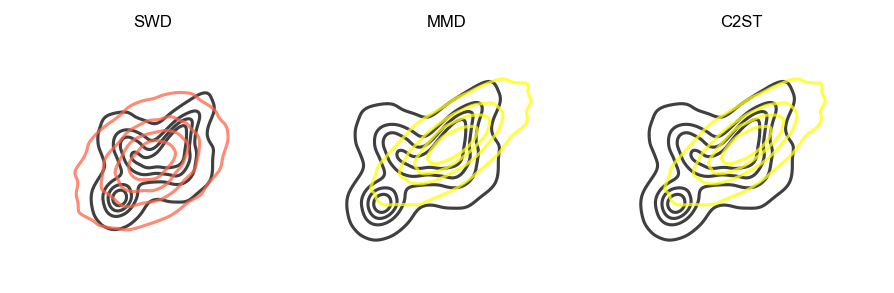

In [11]:
SWD_samples = gauss_model_WS.sample(num_samples).detach().numpy()
MMD_samples = gauss_model_MMD.sample(num_samples).detach().numpy()
C2ST_samples = gauss_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
C2ST_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,3, figsize = (6,2))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)

sns.kdeplot(ax=axs[0],data=SWD_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=MMD_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=C2ST_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)

#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-1.5, 1.5)
#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
axs[0].set_title("SWD")
axs[1].set_title("MMD")
axs[2].set_title("C2ST")

fig.tight_layout()
